In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import os
import glob
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pdb
from keras.utils import np_utils
from os import listdir
from os.path import isfile, join
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from keras.applications import VGG19
from keras.layers import *
from keras import Sequential
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow import keras
from keras.layers import Dropout
from sklearn.utils import class_weight

print(tf.__version__)

2.4.1


In [2]:
# Data parameter
input_dir = os.path.join('..', 'input')
output_dir = os.path.join('..', 'output')

dataset_dir = os.path.join(input_dir, 'landmark-recognition-2020')
train_dir = os.path.join(dataset_dir, 'train')
train_labelmap_dir = os.path.join(dataset_dir, 'train.csv')
test_dir = os.path.join(dataset_dir, 'test')
test_labelmap_dir = os.path.join(dataset_dir, 'sample_submission.csv')

train_df = pd.read_csv(train_labelmap_dir)
test_df = pd.read_csv(test_labelmap_dir)
num_data = len(train_df)

In [3]:
train_dir

'../input/landmark-recognition-2020/train'

In [4]:
print(os.listdir(train_dir))

['7', '2', 'b', 'f', '5', 'e', '8', '0', 'a', '3', '1', 'c', '4', '9', '6', 'd']


In [5]:
train_df.head(10)

,id,landmark_id
0,17660ef415d37059,1
1,92b6290d571448f6,1
2,cd41bf948edc0340,1
3,fb09f1e98c6d2f70,1
4,25c9dfc7ea69838d,7
5,28b13f94a6f1f3c1,7
6,307d6584f473ba35,7
7,4a7ba9eb16d51bc4,7
8,597353dfbb3df649,7
9,a40d00dc4fcc3a10,7


In [6]:
#Adding two extra columns to the data-frame, where filename will be used to retreive the images when needed, and the "label" is the integer version of the "landmark_id"
train_df["filename"] = train_df.id.str[0]+"/"+train_df.id.str[1]+"/"+train_df.id.str[2]+"/"+train_df.id+".jpg"
train_df["label"] = train_df.landmark_id.astype(str)

#Due to the limited resources, i will be keeping only the top 1000 classes of the data.
from collections import Counter

number_of_classes_to_keep = 200
c = train_df.landmark_id.values
count = Counter(c).most_common(number_of_classes_to_keep)
keep_labels = [i[0] for i in count]
train_keep = train_df[train_df.landmark_id.isin(keep_labels)]

#Since we took the 200 most common classes, we will reset the index of the samples in addition to shuffling them.
train_keep = train_keep.sample(frac=1).reset_index(drop=True)
print(train_keep)

                     id  landmark_id                    filename   label
0      5c7e8eefe58f1b1e        70716  5/c/7/5c7e8eefe58f1b1e.jpg   70716
1      e1ee8454c60feb91       136093  e/1/e/e1ee8454c60feb91.jpg  136093
2      df35810f699fa27c       189907  d/f/3/df35810f699fa27c.jpg  189907
3      bfb44068cd5d7909        19605  b/f/b/bfb44068cd5d7909.jpg   19605
4      96c077901fc0f6d8       115821  9/6/c/96c077901fc0f6d8.jpg  115821
...                 ...          ...                         ...     ...
98435  376d02083c937204       138982  3/7/6/376d02083c937204.jpg  138982
98436  ed38dae1b6fdad72       172929  e/d/3/ed38dae1b6fdad72.jpg  172929
98437  94acdd03794621e6       190216  9/4/a/94acdd03794621e6.jpg  190216
98438  e4e71eedf9978660       124455  e/4/e/e4e71eedf9978660.jpg  124455
98439  ded4a2353c2535e7       174834  d/e/d/ded4a2353c2535e7.jpg  174834

[98440 rows x 4 columns]


In [7]:
model = tf.keras.applications.EfficientNetB2(include_top=True, weights=None, input_tensor=None, input_shape=(256, 256, 3), # "weights" is set to None, because the network will use the pretrained network's weights otherwise
    pooling=None, classes=200, classifier_activation='softmax')

In [8]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"])

In [9]:
model.summary()

Model: "efficientnetb2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 256, 256, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 257, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [10]:
BATCH_SIZE = 32

In [11]:
idg = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2, rescale=1.0/255.0)


train_gen = idg.flow_from_dataframe(
    train_keep,
    directory= train_dir +"/",
    x_col="filename",
    y_col="label",
    weight_col=None,
    target_size=(256, 256),
    color_mode="rgb",
    classes=None,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset="training",
    interpolation="nearest",
    validate_filenames=False)
    
val_gen = idg.flow_from_dataframe(
    train_keep,
    directory= train_dir +"/",
    x_col="filename",
    y_col="label",
    weight_col=None,
    target_size=(256, 256),
    color_mode="rgb",
    classes=None,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset="validation",
    interpolation="nearest",
    validate_filenames=False)

Found 78752 non-validated image filenames belonging to 200 classes.
Found 19688 non-validated image filenames belonging to 200 classes.


In [12]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_keep.landmark_id),
                                                 train_keep.landmark_id)
class_weights = dict(enumerate(class_weights))
class_weights

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[    27   1924   5170   6138   6208   9070   9673  10419  13471  13866
  14915  15445  18392  19605  20064  20102  20120  20409  21635  21703
  21843  25093  25457  26967  27190  27364  28139  28641  29794  31361
  31531  31837  31898  32338  33577  33636  33992  36748  38482  38494
  39209  39865  40088  41037  41648  41808  42016  42123  43845  44939
  45428  46705  47133  47378  47880  48753  51272  51856  53170  55219
  55350  56827  57015  57505  57943  60708  60730  64792  65068  65658
  65818  67406  67929  69835  70088  70644  70716  73211  73300  73304
  75005  76303  80147  80177  80272  83144  84939  85633  86869  87157
  90021  90396  90966  91274  96663  98993 100230 100631 101399 102850
 103899 105496 107164 107323 107801 108327 109169 110153 112308 113209
 113462 113636 113838 114289 115821 116124 116255 120144 120734 120885
 122418 124455 124675 125425 125786 126100 126637

{0: 0.9765873015873016,
 1: 0.5213983050847457,
 2: 1.5775641025641025,
 3: 1.582636655948553,
 4: 1.3521978021978023,
 5: 0.5468888888888889,
 6: 1.598051948051948,
 7: 0.6342783505154639,
 8: 1.4022792022792023,
 9: 1.4103151862464183,
 10: 0.6527851458885942,
 11: 1.15,
 12: 1.3375,
 13: 1.0004065040650407,
 14: 1.2817708333333333,
 15: 1.3825842696629214,
 16: 0.5542792792792792,
 17: 0.2799772468714448,
 18: 1.355922865013774,
 19: 1.4062857142857144,
 20: 1.5775641025641025,
 21: 0.7423831070889895,
 22: 1.4870090634441087,
 23: 1.5238390092879257,
 24: 0.9465384615384616,
 25: 1.6298013245033112,
 26: 1.0127572016460906,
 27: 1.177511961722488,
 28: 1.0630669546436284,
 29: 1.0962138084632516,
 30: 0.9746534653465346,
 31: 1.5098159509202453,
 32: 1.5098159509202453,
 33: 1.619078947368421,
 34: 1.5144615384615385,
 35: 1.5928802588996764,
 36: 1.4184438040345821,
 37: 0.5866507747318236,
 38: 0.6991477272727272,
 39: 1.2243781094527364,
 40: 1.4184438040345821,
 41: 1.088938053

In [13]:
# training parameters

EPOCHS = 40
train_steps = int(len(train_keep)*(1-0.2))//BATCH_SIZE
val_steps = int(len(train_keep)*0.2)//BATCH_SIZE

train_steps = train_steps * 0.25
val_steps = val_steps * 0.25

print(train_steps)
print(val_steps)

model_checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_categorical_accuracy', mode='max', verbose=1)

615.25
153.75


In [14]:
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [15]:
history = model.fit(train_gen, validation_data=val_gen, steps_per_epoch=train_steps, epochs = EPOCHS, validation_steps=val_steps, class_weight=class_weights, callbacks=[model_checkpoint])

model.save("model.h5")

Epoch 1/40
615/615 [==============================] - 501s 790ms/step - loss: 6.2284 - categorical_accuracy: 0.0793 - val_loss: 7.4020 - val_categorical_accuracy: 0.0118

Epoch 00001: val_categorical_accuracy improved from -inf to 0.01177, saving model to best_model.h5
Epoch 2/40
615/615 [==============================] - 464s 754ms/step - loss: 5.3687 - categorical_accuracy: 0.1182 - val_loss: 4.0424 - val_categorical_accuracy: 0.1648

Epoch 00002: val_categorical_accuracy improved from 0.01177 to 0.16477, saving model to best_model.h5
Epoch 3/40
615/615 [==============================] - 390s 633ms/step - loss: 4.7911 - categorical_accuracy: 0.1703 - val_loss: 3.6425 - val_categorical_accuracy: 0.2281

Epoch 00003: val_categorical_accuracy improved from 0.16477 to 0.22808, saving model to best_model.h5
Epoch 4/40
615/615 [==============================] - 334s 543ms/step - loss: 4.2514 - categorical_accuracy: 0.2305 - val_loss: 3.3689 - val_categorical_accuracy: 0.2640

Epoch 00004: 

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


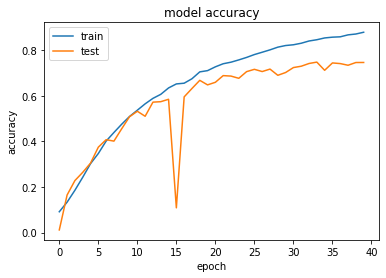

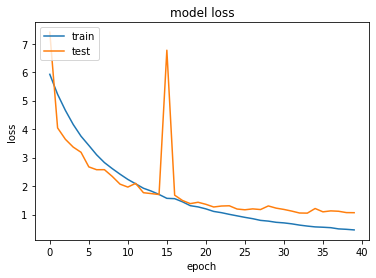

In [16]:
print(history.history.keys())
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
#sub = pd.read_csv("/kaggle/input/landmark-recognition-2020/sample_submission.csv")
test_df["filename"] = test_df.id.str[0]+"/"+test_df.id.str[1]+"/"+test_df.id.str[2]+"/"+test_df.id+".jpg"

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/.255).flow_from_dataframe(
    test_df,
    directory= test_dir + "/",
    x_col="filename",
    y_col=None,
    weight_col=None,
    target_size=(224, 224),
    color_mode="rgb",
    classes=None,
    class_mode=None,
    batch_size=1,
    shuffle=True,
    subset=None,
    interpolation="nearest",
    validate_filenames=False)

y_pred = model.predict(test_gen, verbose=1)

Found 10345 non-validated image filenames.
10345/10345 [==============================] - 181s 17ms/step


In [18]:
predict = model.predict(val_gen, val_steps,verbose=1)

good_preds = []
bad_preds = []

val_filenames = val_gen.filenames
label_map = (val_gen.class_indices)
#label_categories = to_categorical(np.asarray(labels)) 
cla = np.argmax(predict, axis=1)
label_map = list(map(int, label_map.keys()))
val_label = val_gen.labels

for idx, res in enumerate(predict):
    #print("image_id: ", val_filenames[idx], ", class predict: ", label_map[cla[idx]], "class: ", label_map[val_label[idx]])
    
    if label_map[cla[idx]] != label_map[val_label[idx]]:
        bad_preds.append([val_filenames[idx], label_map[cla[idx]], label_map[val_label[idx]], res[cla[idx]]])
    else:
        good_preds.append([val_filenames[idx], label_map[cla[idx]], label_map[val_label[idx]], res[cla[idx]]])
print("wrong predictions: ", len(bad_preds), " right predictions: ", len(good_preds), " acc: ", np.round(100*(len(predict)-len(bad_preds))/len(predict),2))

616/616 [==============================] - 168s 270ms/step
wrong predictions:  19491  right predictions:  197  acc:  1.0


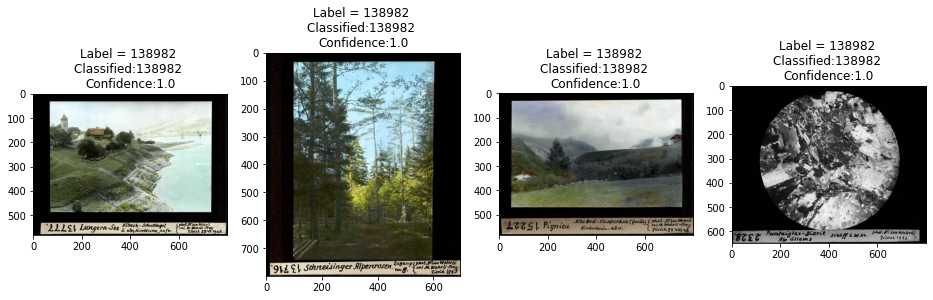

In [19]:
### plot some of the best predictions
fig=plt.figure(figsize=(16, 8))

good_preds = np.array(good_preds)
good_preds = np.array(sorted(good_preds, key = lambda x: x[3], reverse=True))
#print(good_preds.shape)

columns = 4
rows = 1
for i in range(1, columns*rows +1):
    n = good_preds[i,0]
    #print(n)
    img = cv2.imread(os.path.join(train_dir,n))
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    lbl = good_preds[i,2]
    fig.add_subplot(rows, columns, i)
    plt.imshow(RGB_img)
    lbl2 = good_preds[i,1]
    plt.title("Label = " + str(lbl) + " \nClassified:" + str(lbl2) + " \nConfidence:" + str(good_preds[i,3]))
plt.show()

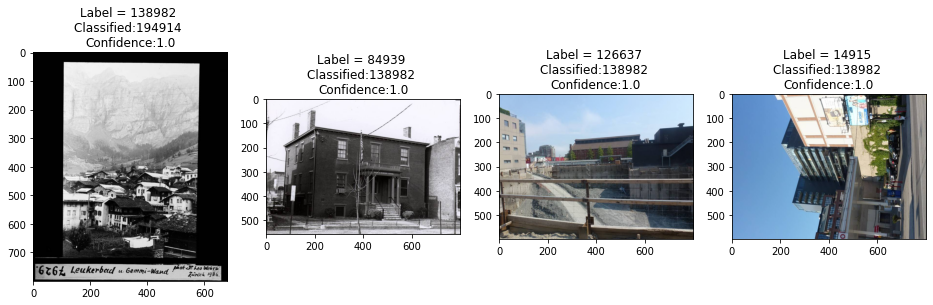

In [20]:
### plot the worst predictions

fig=plt.figure(figsize=(16, 8))

bad_preds = np.array(bad_preds)
bad_preds = np.array(sorted(bad_preds, key = lambda x: x[3], reverse=True))
#print(bad_preds.shape)

columns = 4
rows = 1
for i in range(1, columns*rows +1):
    n = bad_preds[i,0]
    #print(n)
    img = cv2.imread(os.path.join(train_dir,n))
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    lbl = bad_preds[i,2]
    fig.add_subplot(rows, columns, i)
    plt.imshow(RGB_img)
    lbl2 = bad_preds[i,1]
    plt.title("Label = " + str(lbl) + " \nClassified:" + str(lbl2) + " \nConfidence:" + str(good_preds[i,3]))
plt.show()

In [21]:
train_val = train_keep.landmark_id.value_counts()
train_keep_df = pd.DataFrame({'landmark_id':train_val.index, 'frequency':train_val.values})
train_keep_df.reset_index(inplace=True)

print("Top 5 training classes with most data:")
for i in range(5):
    print("label:", train_keep_df.landmark_id[i], "has", train_keep_df.frequency[i], "instances in training set" )

train_keep_df.set_index("landmark_id", inplace = True)
print("\nTop 5 classes with the worst prediction")
    
for i in range(5):
    label = bad_preds[i, 2]
    #print(label)
    label_counts = train_keep_df.loc[int(label)]
    #print(label_counts)
    print("label:", label, "has", label_counts["frequency"], "instances in training set" )
    
    print("\nTop 5 classes with the best prediction")
for i in range(5):
    label = good_preds[i, 2]
    #print(label)
    label_counts = train_keep_df.loc[int(label)]
    #print(label_counts)
    print("label:", label, "has", label_counts["frequency"], "instances in training set" )

Top 5 training classes with most data:
label: 138982 has 6272 instances in training set
label: 126637 has 2231 instances in training set
label: 20409 has 1758 instances in training set
label: 83144 has 1741 instances in training set
label: 113209 has 1135 instances in training set

Top 5 classes with the worst prediction
label: 67406 has 390 instances in training set

Top 5 classes with the best prediction
label: 138982 has 6272 instances in training set

Top 5 classes with the best prediction
label: 84939 has 323 instances in training set

Top 5 classes with the best prediction
label: 126637 has 2231 instances in training set

Top 5 classes with the best prediction
label: 14915 has 754 instances in training set

Top 5 classes with the best prediction
label: 138982 has 6272 instances in training set
label: 138982 has 6272 instances in training set
label: 138982 has 6272 instances in training set
label: 138982 has 6272 instances in training set
label: 138982 has 6272 instances in traini

In [22]:
y_pred

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [23]:
y_prob = np.max(y_pred, axis=-1)
y_pred = np.argmax(y_pred, axis=-1)
print(y_pred.shape, y_prob.shape)

(10345,) (10345,)


In [24]:
thresh = 0.5

for i in range(len(test_df)):
    prob = y_prob[i]
    pred = y_pred[i]
    if prob >= 0.3:
        st = str(pred)+" "+str(prob)
    else:
        st = ""
    test_df.loc[i, "landmarks"] = st
test_df = test_df.drop(columns="filename")
test_df.to_csv("submission.csv", index=False)
test_df

,id,landmarks
0,00084cdf8f600d00,118 1.0
1,000b15b043eb8cf0,63 1.0
2,0011a52f9b948fd2,130 1.0
3,00141b8a5a729084,93 1.0
4,0018aa4b92532b77,20 1.0
...,...,...
10340,ffc41ddbcf63289b,166 1.0
10341,ffd4c19b7732cbe9,30 1.0
10342,ffee2cac79a173d6,22 1.0
10343,ffef459d5dc6b981,87 1.0


In [25]:
prob

0.9910898

In [26]:
model = keras.models.load_model("model.h5")

In [27]:
history = model.fit(train_gen, validation_data=val_gen, steps_per_epoch=train_steps, epochs = 10, validation_steps=val_steps, class_weight=class_weights)



Epoch 1/10
615/615 [==============================] - 307s 489ms/step - loss: 0.4607 - categorical_accuracy: 0.8747 - val_loss: 1.4601 - val_categorical_accuracy: 0.6688
Epoch 2/10
615/615 [==============================] - 300s 488ms/step - loss: 0.4282 - categorical_accuracy: 0.8835 - val_loss: 1.1451 - val_categorical_accuracy: 0.7453
Epoch 3/10
615/615 [==============================] - 297s 483ms/step - loss: 0.4030 - categorical_accuracy: 0.8889 - val_loss: 1.0601 - val_categorical_accuracy: 0.7563
Epoch 4/10
615/615 [==============================] - 299s 485ms/step - loss: 0.4103 - categorical_accuracy: 0.8873 - val_loss: 1.0071 - val_categorical_accuracy: 0.7739
Epoch 5/10
615/615 [==============================] - 297s 482ms/step - loss: 0.3836 - categorical_accuracy: 0.8942 - val_loss: 1.0128 - val_categorical_accuracy: 0.7675
Epoch 6/10
615/615 [==============================] - 297s 483ms/step - loss: 0.3639 - categorical_accuracy: 0.8983 - val_loss: 1.0404 - val_categoric

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


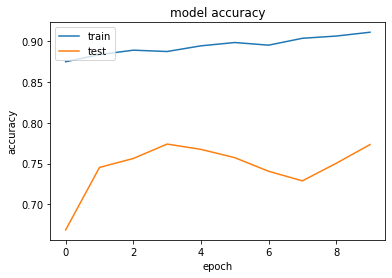

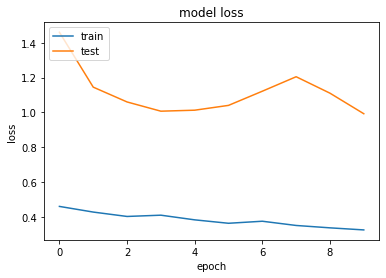

In [28]:
print(history.history.keys())
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
#sub = pd.read_csv("/kaggle/input/landmark-recognition-2020/sample_submission.csv")
test_df["filename"] = test_df.id.str[0]+"/"+test_df.id.str[1]+"/"+test_df.id.str[2]+"/"+test_df.id+".jpg"

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/.255).flow_from_dataframe(
    test_df,
    directory= test_dir + "/",
    x_col="filename",
    y_col=None,
    weight_col=None,
    target_size=(224, 224),
    color_mode="rgb",
    classes=None,
    class_mode=None,
    batch_size=1,
    shuffle=True,
    subset=None,
    interpolation="nearest",
    validate_filenames=False)

y_pred = model.predict(test_gen, verbose=1)

Found 10345 non-validated image filenames.
10345/10345 [==============================] - 144s 14ms/step


In [30]:
predict = model.predict(val_gen, val_steps,verbose=1)

good_preds = []
bad_preds = []

val_filenames = val_gen.filenames
label_map = (val_gen.class_indices)
#label_categories = to_categorical(np.asarray(labels)) 
cla = np.argmax(predict, axis=1)
label_map = list(map(int, label_map.keys()))
val_label = val_gen.labels

for idx, res in enumerate(predict):
    #print("image_id: ", val_filenames[idx], ", class predict: ", label_map[cla[idx]], "class: ", label_map[val_label[idx]])
    
    if label_map[cla[idx]] != label_map[val_label[idx]]:
        bad_preds.append([val_filenames[idx], label_map[cla[idx]], label_map[val_label[idx]], res[cla[idx]]])
    else:
        good_preds.append([val_filenames[idx], label_map[cla[idx]], label_map[val_label[idx]], res[cla[idx]]])
print("wrong predictions: ", len(bad_preds), " right predictions: ", len(good_preds), " acc: ", np.round(100*(len(predict)-len(bad_preds))/len(predict),2))

616/616 [==============================] - 155s 249ms/step
wrong predictions:  19510  right predictions:  178  acc:  0.9


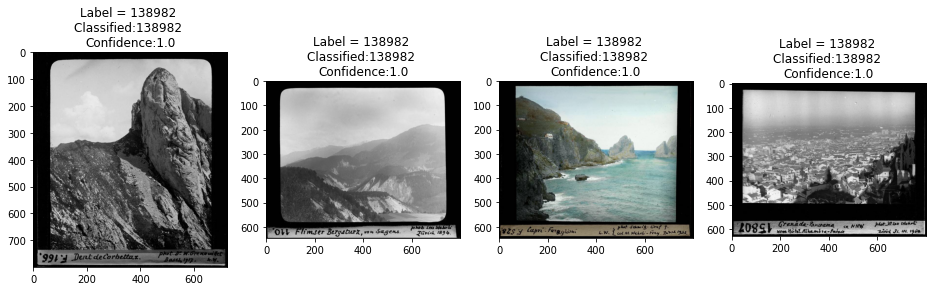

In [31]:
### plot some of the best predictions
fig=plt.figure(figsize=(16, 8))

good_preds = np.array(good_preds)
good_preds = np.array(sorted(good_preds, key = lambda x: x[3], reverse=True))
#print(good_preds.shape)

columns = 4
rows = 1
for i in range(1, columns*rows +1):
    n = good_preds[i,0]
    #print(n)
    img = cv2.imread(os.path.join(train_dir,n))
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    lbl = good_preds[i,2]
    fig.add_subplot(rows, columns, i)
    plt.imshow(RGB_img)
    lbl2 = good_preds[i,1]
    plt.title("Label = " + str(lbl) + " \nClassified:" + str(lbl2) + " \nConfidence:" + str(good_preds[i,3]))
plt.show()

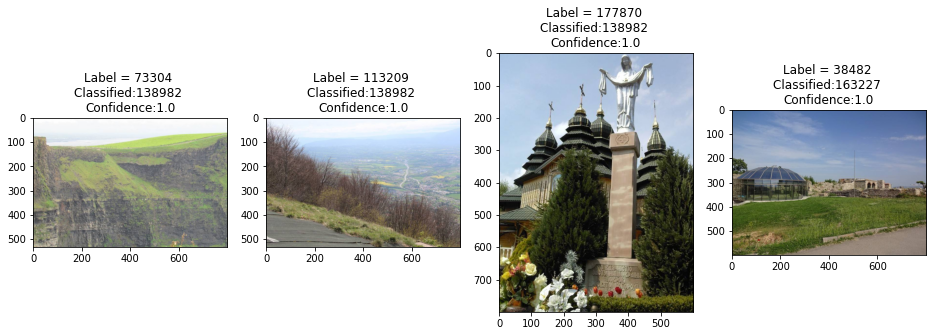

In [32]:
### plot the worst predictions

fig=plt.figure(figsize=(16, 8))

bad_preds = np.array(bad_preds)
bad_preds = np.array(sorted(bad_preds, key = lambda x: x[3], reverse=True))
#print(bad_preds.shape)

columns = 4
rows = 1
for i in range(1, columns*rows +1):
    n = bad_preds[i,0]
    #print(n)
    img = cv2.imread(os.path.join(train_dir,n))
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    lbl = bad_preds[i,2]
    fig.add_subplot(rows, columns, i)
    plt.imshow(RGB_img)
    lbl2 = bad_preds[i,1]
    plt.title("Label = " + str(lbl) + " \nClassified:" + str(lbl2) + " \nConfidence:" + str(good_preds[i,3]))
plt.show()

In [33]:
train_val = train_keep.landmark_id.value_counts()
train_keep_df = pd.DataFrame({'landmark_id':train_val.index, 'frequency':train_val.values})
train_keep_df.reset_index(inplace=True)

print("Top 5 training classes with most data:")
for i in range(5):
    print("label:", train_keep_df.landmark_id[i], "has", train_keep_df.frequency[i], "instances in training set" )

train_keep_df.set_index("landmark_id", inplace = True)
print("\nTop 5 classes with the worst prediction")
    
for i in range(5):
    label = bad_preds[i, 2]
    #print(label)
    label_counts = train_keep_df.loc[int(label)]
    #print(label_counts)
    print("label:", label, "has", label_counts["frequency"], "instances in training set" )
    
    print("\nTop 5 classes with the best prediction")
for i in range(5):
    label = good_preds[i, 2]
    #print(label)
    label_counts = train_keep_df.loc[int(label)]
    #print(label_counts)
    print("label:", label, "has", label_counts["frequency"], "instances in training set" )

Top 5 training classes with most data:
label: 138982 has 6272 instances in training set
label: 126637 has 2231 instances in training set
label: 20409 has 1758 instances in training set
label: 83144 has 1741 instances in training set
label: 113209 has 1135 instances in training set

Top 5 classes with the worst prediction
label: 70716 has 331 instances in training set

Top 5 classes with the best prediction
label: 73304 has 334 instances in training set

Top 5 classes with the best prediction
label: 113209 has 1135 instances in training set

Top 5 classes with the best prediction
label: 177870 has 1088 instances in training set

Top 5 classes with the best prediction
label: 38482 has 704 instances in training set

Top 5 classes with the best prediction
label: 138982 has 6272 instances in training set
label: 138982 has 6272 instances in training set
label: 138982 has 6272 instances in training set
label: 138982 has 6272 instances in training set
label: 138982 has 6272 instances in traini